# 1. Setup

## 1.1 Import Packages

In [62]:
#Import Python packages
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
import json
import datetime
import numpy as np
from matplotlib.gridspec import GridSpec
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# for splitting of the dataset
from sklearn.model_selection import train_test_split

# for encoding/transforming the data
from feature_engine.encoding import OneHotEncoder
from feature_engine.encoding import RareLabelEncoder
from feature_engine.outliers import Winsorizer
from feature_engine.transformation import YeoJohnsonTransformer
from sklearn.preprocessing import MinMaxScaler

#ML-Models: Regression
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor

#Building clustering model
from sklearn.cluster import KMeans 

# for getting metrics
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score

# model selection
from sklearn.model_selection import GridSearchCV

# Import Snowflake modules
from snowflake.snowpark import Session
import snowflake.snowpark.functions as F
import snowflake.snowpark.types as T
from snowflake.snowpark import Window
# Define a simple scoring function
from cachetools import cached

## 1.2 Connect to Snowflake

In [2]:
# Get account credentials from a json file
with open("data_scientist_auth.json") as f:
    data = json.load(f)
    username = data["username"]
    password = data["password"]
    account = data["account"]

# Specify connection parameters
connection_parameters = {
    "account": account,
    "user": username,
    "password": password,
    "role": "TASTY_BI",
    "warehouse": "TASTY_BI_WH",
    "database": "frostbyte_tasty_bytes",
    "schema": "analytics",
}

# Create Snowpark session
session = Session.builder.configs(connection_parameters).create()

In [3]:
session.sql("ALTER WAREHOUSE TASTY_BI_WH SET WAREHOUSE_SIZE = MEDIUM").collect()

[Row(status='Statement executed successfully.')]

## 1.3 Gathering Data as Snowpark DataFrame

In [4]:
# Orders_V
# contains orders, trucks, shift information
tasty_bytes_orders_v = session.table("frostbyte_tasty_bytes.analytics.orders_v")
# Customer Loyalty
# contains information on signed up members
tasty_bytes_customer_loyalty = session.table("frostbyte_tasty_bytes.raw_customer.customer_loyalty")

locations= session.table("frostbyte_tasty_bytes.raw_pos.location")

menu= session.table("frostbyte_tasty_bytes.raw_pos.menu")
#Sentiment_Survey_ds
# contains NPS score
SENTIMENT_DATA = session.table("ngee_ann_polytechnic_frostbyte_data_share.raw_survey.sentiment_survey_ds")
# Truck information data
TRUCK_DATA = session.table("NGEE_ANN_POLYTECHNIC_FROSTBYTE_DATA_SHARE.raw_pos.truck")
# Comparison Data
NPS_COMPARE = session.table("NPS_COMPARE")

# 2. Data Exploration 

## 2.0 Model Value Towards Tasty Byte KPI

### 2.0.1 Define function - Remove Duplicate Columns from Joins

In [5]:
#Function to remove and rename columns after inner join
def remove_dup_join_col(df):
    # capitalise all columns
    for col in df.columns:
        df = df.withColumnRenamed(col, col.upper())
    
    # get list of renamable columns for left and right join
    left_dup_col = [col_name for col_name in df.columns if col_name.startswith('L_')]
    right_dup_col = [col_name for col_name in df.columns if col_name.startswith('R_')]
    old_columns = df.columns
    
    # rename the list with the most number of renamable columns
    # drop the list of columns with less number of renamable columns
    if len(left_dup_col)>len(right_dup_col):
        columns_rename=left_dup_col
        df= df.drop(*right_dup_col)
    else:
        columns_rename=right_dup_col
        df= df.drop(*left_dup_col)
    
    for old_column in old_columns:
        if old_column in columns_rename:
            # get string to remove
            string_to_replace = columns_rename[0][:7]
            # replace starting string
            new_column = old_column.replace(string_to_replace, "")
            df = df.withColumnRenamed(old_column, new_column)
    
    return df

We get the churn cut off date by country. This is done by subtracting 14 days from the latest order date, with 14 days being the assumed churn period. These values are compared with the time stamp so that we can identify which customers were active within the time frame and how many left. 

<b>We decided to work on United States as it has the most number of customers, a high number of customers and quite a high Churn Rate.

# 3. Data Engineering

## 3.1 Generate new Columns

In [6]:
#Merge to get loyal customers orders
loyal_customer_orders=tasty_bytes_orders_v.join(
    right=tasty_bytes_customer_loyalty,
    on="CUSTOMER_ID",
    how="inner"
)

In [7]:
#Remove duplicate columns
loyal_customer_orders = remove_dup_join_col(loyal_customer_orders)

#Remove duplicate order ids
remove_dup = loyal_customer_orders.dropDuplicates(['ORDER_ID'])

In [8]:
remove_dup=remove_dup.filter(F.col('COUNTRY')=='United States')

In [9]:
remove_dup.agg(F.max(F.col('ORDER_TS'))).show()

-----------------------
|"MAX(ORDER_TS)"      |
-----------------------
|2022-11-01 22:58:56  |
-----------------------



In [10]:
target_info=remove_dup.filter((F.year('ORDER_TS') < 2022) | ((F.year('ORDER_TS') == 2022) & (F.month('ORDER_TS') < 11)))

In [11]:
monetary_pred=target_info.group_by('CUSTOMER_ID').agg(F.sum('ORDER_TOTAL').alias('Next_Month_Monetary'))

In [12]:
filtered_df=remove_dup.filter((F.year('ORDER_TS') < 2022) | ((F.year('ORDER_TS') == 2022) & (F.month('ORDER_TS') < 10)))

We got the latest order date to filter out the last purchase and its also used to get the days to next order. Since our target variable is closely related to the days to next order, we filter out the last purchase to not leak future information such that we are able to prevent target leakage.

### 3.1.2 RFM (Recency, Freqency, Monetary)

In [13]:
# Get last purchase date as a variable
lastdate=filtered_df.select(F.max('ORDER_TS')).first()[0]


# Frequency
frequency = filtered_df.groupBy('CUSTOMER_ID').agg(F.countDistinct('ORDER_ID').alias('frequency'))

# Monetary
monetary = filtered_df.groupBy('CUSTOMER_ID').agg(F.sum('ORDER_TOTAL').alias('monetary'))

# Merge into RFM table
FM_table = frequency.join(monetary, on='CUSTOMER_ID', how='inner')


This code is used to get RFM, Recency, Frequency, and Monetary for each customer. The purpose of doing this is to generate new features and show the customer's behavioural data.

In [14]:
# Assuming filtered_df contains the DataFrame with customer_id and order_ts columns
window_spec = Window.partitionBy('customer_id').orderBy(F.col('order_ts').asc())

# Add rank to each order for each customer
orders_with_rank = filtered_df.withColumn('rank', F.rank().over(window_spec))

# Get the first order of each customer
first_order_ts = orders_with_rank.filter(F.col('rank') == 1).select('customer_id', 'order_ts')

In [15]:
first_order_ts=first_order_ts.withColumn('last_date', F.lit(lastdate))

In [16]:
# Calculate the difference in days between the first and last order
tenure = first_order_ts.withColumn('Tenure_days', F.datediff(col1='order_ts', col2='last_date',part='day'))
tenure=tenure.withColumn('Tenure_months', F.datediff(col1='order_ts', col2='last_date',part='month'))

tenure=tenure.drop(['ORDER_TS','last_date'])

tenure.show()

---------------------------------------------------
|"CUSTOMER_ID"  |"TENURE_DAYS"  |"TENURE_MONTHS"  |
---------------------------------------------------
|142682         |1033           |33               |
|76011          |993            |32               |
|78119          |1034           |33               |
|165914         |1082           |35               |
|25204          |1002           |32               |
|93606          |1243           |40               |
|168060         |1003           |32               |
|147003         |998            |32               |
|152300         |1089           |35               |
|87462          |1077           |35               |
---------------------------------------------------



In [17]:
avg_Sales=filtered_df.group_by('CUSTOMER_ID').agg(F.round(F.avg('ORDER_TOTAL'),2).alias('AVG_SALES_ORDER'))

### 3.1.5 Join Generated Variables

In [18]:
# Merge to get final dataframe
final_df = FM_table.join(tenure,on='CUSTOMER_ID',how='inner')
final_df = final_df.join(avg_Sales,on='CUSTOMER_ID',how='inner')
final_df = final_df.join(monetary_pred,on='CUSTOMER_ID',how='inner')

In [19]:
# Sort CustomerID
final_df=final_df.sort('CUSTOMER_ID')

In [20]:
# Convert to pandas
final_df=final_df.to_pandas()

We converted the table to pandas because we want to carry out data manipulation.

## 3.2 Outlier Handling

### 3.2.1 Identify Numericals

In [21]:
final_df=final_df.drop(['ORDER_TS','MAX_ORDER_TS','TENURE_DAYS','RECENCY'],axis=1,errors='ignore')

In [22]:
final_df['AVG_SALES_ORDER'] = final_df['AVG_SALES_ORDER'].astype(float)

In [23]:
num_cols=final_df.select_dtypes(exclude=['object','datetime64[ns]']).columns

### 3.2.2 Visualise Outliers

In [24]:
# Function to explore the distributuion of variables
def diagnostic_plots(df, variable):
    # function takes a dataframe (df) and
    # the variable of interest as arguments

    # define figure size
    fig=plt.figure(figsize=(8, 4))
    fig.suptitle(variable)
    
    # histogram
    plt.subplot(1, 2, 1)
    sns.histplot(df[variable], bins=30,kde=True)
    plt.title('Histogram')

    # boxplot
    plt.subplot(1, 2, 2)
    sns.boxplot(y=df[variable])
    plt.title('Boxplot')
    
    plt.show()

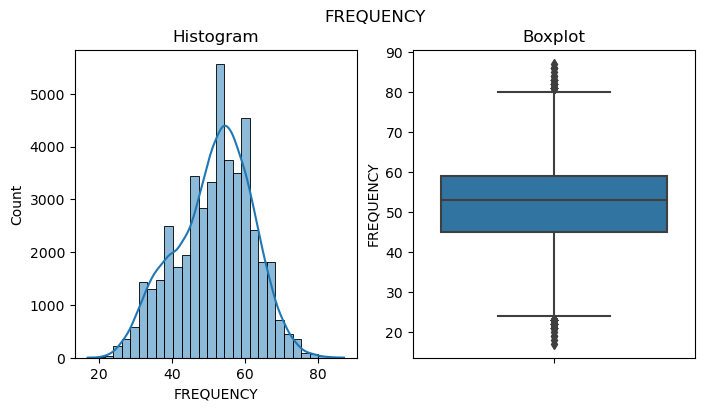

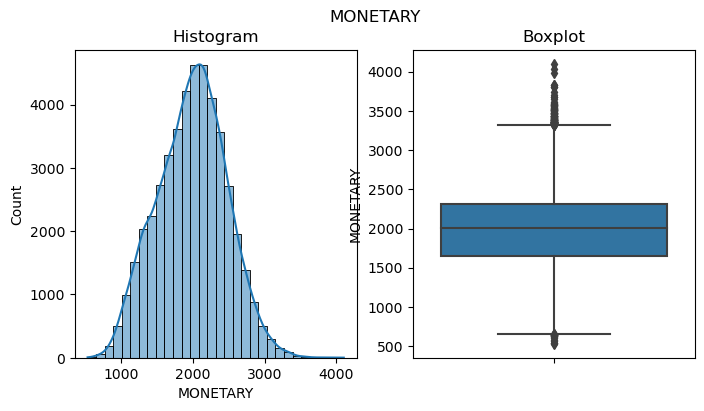

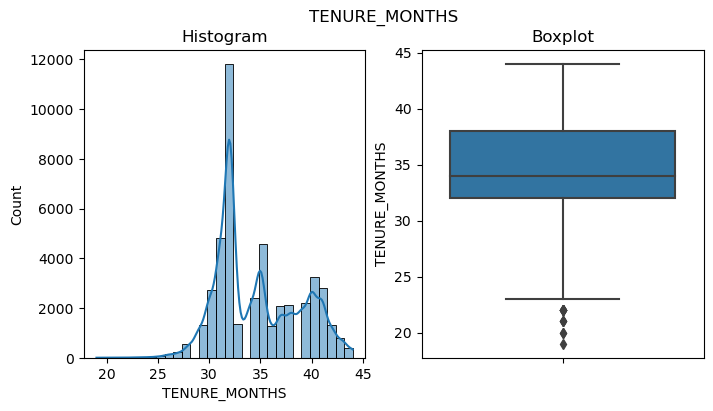

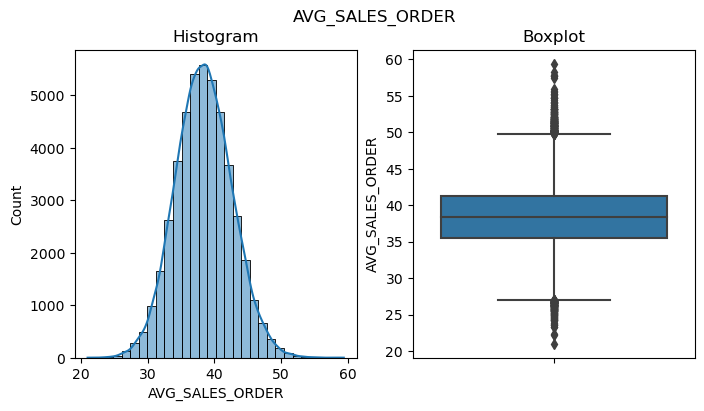

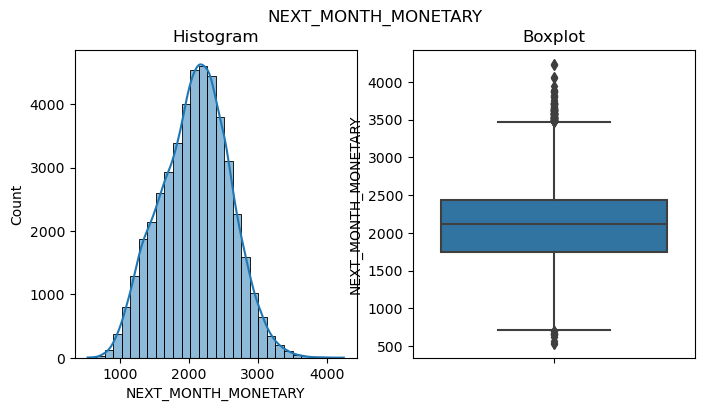

In [25]:
for i in num_cols.drop(['CUSTOMER_ID']):
    diagnostic_plots(final_df,i)
    plt.show()

### 3.2.3 Cap the Outliers

#### 3.2.3.1 Cap by gaussian

In [37]:
# create the capper
windsorizer = Winsorizer(capping_method='gaussian', # choose iqr for skewed or gaussian for normal
                          tail='both', # cap left, right or both tails 
                          fold=3,
                          variables=['FREQUENCY','MONETARY','AVG_SALES_ORDER'])

windsorizer.fit(final_df)

Winsorizer(tail='both', variables=['FREQUENCY', 'MONETARY', 'AVG_SALES_ORDER'])

In [38]:
final_df_win = windsorizer.transform(final_df)

Cap by gaussian for distributions with a normal ditribution. (Outliers = 3 Standard-deviations away)

# 4 Split the Data

In [47]:
# Train test split
X = final_df[['MONETARY','FREQUENCY','AVG_SALES_ORDER','TENURE_MONTHS']]
y = final_df["NEXT_MONTH_MONETARY"]


X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.6,random_state=42)

In [48]:
# Test and holdout split
X_test,X_holdout,y_test,y_holdout=train_test_split(X_test,y_test,test_size=0.5,random_state=42)

## 4.1 Data Engineering 2

Data engineering needs to be done in 2 parts, one before and one after splitting the data so as to prevent data leakage to the test datasets

### 4.1.2 Feature Scaling

#### 4.1.2.1 Min Max Scaler

In [49]:
# Min Max Scaler
cols_to_scale=X_train.columns

scaler = MinMaxScaler()

# fit the scaler to the train set, it will learn the parameters
scaler.fit(X_train[cols_to_scale])

# transform train and test sets
X_train[cols_to_scale] = scaler.transform(X_train[cols_to_scale])
X_test[cols_to_scale]= scaler.transform(X_test[cols_to_scale])
X_holdout[cols_to_scale]=scaler.transform(X_holdout[cols_to_scale])

# 5. Model Building

## 5.1 Define Evaluation Function

In [50]:
def evaluateRegressionModelPerformance(model, X_train, X_test, X_holdout, y_train, y_test, y_holdout):
    # Training evaluation
    print('Training Set:')
    train_pred=model.predict(X_train)
    print('Mean Squared Error:', mean_squared_error(train_pred, y_train))
    print('Root Mean Squared Error:', np.sqrt(mean_squared_error(train_pred, y_train)))
    print('R-squared:', r2_score(y_train, train_pred))
    print()

    # Testing evaluation
    print('Testing Set:')
    test_pred=model.predict(X_test)
    print('Mean Squared Error:', mean_squared_error(test_pred, y_test))
    print('Root Mean Squared Error:', np.sqrt(mean_squared_error(test_pred, y_test)))
    print('R-squared:', r2_score(y_test, test_pred))
    print()

    # Holdout evaluation
    print('Holdout Set:')
    holdout_pred=model.predict(X_holdout)
    print('Mean Squared Error:', mean_squared_error(holdout_pred, y_holdout))
    print('Root Mean Squared Error:', np.sqrt(mean_squared_error(holdout_pred, y_holdout)))
    print('R-squared:', r2_score(y_holdout, holdout_pred))

## Linear Regression

In [64]:
#Building LR Model
lm = LinearRegression()
lm.fit(X_train, y_train)
evaluateRegressionModelPerformance(lm, X_train, X_test, X_holdout, y_train, y_test, y_holdout)


Training Set:
Mean Squared Error: 6234.637093952581
Root Mean Squared Error: 78.95971817295565
R-squared: 0.9747827974393153

Testing Set:
Mean Squared Error: 5966.293638119821
Root Mean Squared Error: 77.24178686514068
R-squared: 0.9757476141729757

Holdout Set:
Mean Squared Error: 5929.610722987092
Root Mean Squared Error: 77.00396563156401
R-squared: 0.9762448835370456


## Decision Tree Regression

In [65]:
#Create Decision Tree Model
tree_reg = DecisionTreeRegressor(max_depth=2, random_state=2)
tree_reg.fit(X_train, y_train)
evaluateRegressionModelPerformance(tree_reg, X_train, X_test, X_holdout, y_train, y_test, y_holdout)

Training Set:
Mean Squared Error: 31619.191246211485
Root Mean Squared Error: 177.81785975039594
R-squared: 0.8721100300714941

Testing Set:
Mean Squared Error: 31664.48127828989
Root Mean Squared Error: 177.94516368333782
R-squared: 0.8712870563280427

Holdout Set:
Mean Squared Error: 31472.661488559883
Root Mean Squared Error: 177.40535924418936
R-squared: 0.8739147013206882


## Random ForestRegression

In [68]:
#Create Random Forest Model
rf_reg = RandomForestRegressor(max_depth=2, random_state=1, n_estimators=20)
rf_reg.fit(X_train, y_train) 
evaluateRegressionModelPerformance(rf_reg, X_train, X_test, X_holdout, y_train, y_test, y_holdout)

Training Set:
Mean Squared Error: 27914.31323206355
Root Mean Squared Error: 167.0757709306276
R-squared: 0.8870951299157203

Testing Set:
Mean Squared Error: 27888.36315834388
Root Mean Squared Error: 166.99809327756972
R-squared: 0.8866365981253533

Holdout Set:
Mean Squared Error: 27815.18735119263
Root Mean Squared Error: 166.77885762647685
R-squared: 0.8885672186868929


## Ada Boost Regression

In [69]:
ada_reg = AdaBoostRegressor(DecisionTreeRegressor(max_depth=2), 
                            n_estimators=200, 
                            learning_rate=0.5)

ada_reg.fit(X_train, y_train)
evaluateRegressionModelPerformance(ada_reg, X_train, X_test, X_holdout, y_train, y_test, y_holdout)

Training Set:
Mean Squared Error: 12181.120654324664
Root Mean Squared Error: 110.36811430084626
R-squared: 0.9507310879001771

Testing Set:
Mean Squared Error: 12244.691290703868
Root Mean Squared Error: 110.65573320304676
R-squared: 0.9502265567994174

Holdout Set:
Mean Squared Error: 12004.935739136203
Root Mean Squared Error: 109.56703764881208
R-squared: 0.9519060086848665


## XGBoost Regressor

In [67]:
xgb_before = XGBRegressor(max_depth=2, learning_rate = 0.1, use_label_encoder = False, eval_metric='logloss')
# fit the model to the training data
xgb_before.fit(X_train, y_train)

evaluateRegressionModelPerformance(xgb_before, X_train, X_test, X_holdout, y_train, y_test, y_holdout)

Training Set:
Mean Squared Error: 6069.687413483533
Root Mean Squared Error: 77.90819862815167
R-squared: 0.9754499685099046

Testing Set:
Mean Squared Error: 6062.342475059033
Root Mean Squared Error: 77.86104594120883
R-squared: 0.9753571852747391

Holdout Set:
Mean Squared Error: 6014.271955369497
Root Mean Squared Error: 77.55173728144004
R-squared: 0.9759057149930896


In [52]:
# Training Set:
# Mean Squared Error: 74760.46134180382
# Root Mean Squared Error: 273.4235932427994
# R-squared: 0.6976167708277452

# Testing Set:
# Mean Squared Error: 74587.52216560276
# Root Mean Squared Error: 273.10716242091263
# R-squared: 0.6968091959329081

# Holdout Set:
# Mean Squared Error: 74142.11414888754
# Root Mean Squared Error: 272.2904958842441
# R-squared: 0.7029729878238564

In [53]:
param_grid = {'n_estimators': [30, 40, 50, 60],
              'learning_rate': [0.1, 0.2, 0.3, 0.4],
              'max_depth': [4,5,6,7]}

xgb_grid = GridSearchCV(xgb_before, param_grid, cv=5)
xgb_grid.fit(X_train, y_train)

print("Best parameters found: ", xgb_grid.best_params_)
print("Best score found: ", xgb_grid.best_score_)

Best parameters found:  {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 60}
Best score found:  0.9745648679910357


In [54]:
# Build XGBoost Model
xgb_improved = XGBRegressor(learning_rate = 0.1, max_depth =4, n_estimators = 60)
# fit the model to the training data
xgb_improved.fit(X_train, y_train)

evaluateRegressionModelPerformance(xgb_improved, X_train, X_test, X_holdout, y_train, y_test, y_holdout)

Training Set:
Mean Squared Error: 5961.512702207682
Root Mean Squared Error: 77.21083280348479
R-squared: 0.9758875021730641

Testing Set:
Mean Squared Error: 6029.729382458787
Root Mean Squared Error: 77.65133213576433
R-squared: 0.9754897542283858

Holdout Set:
Mean Squared Error: 5973.140592484117
Root Mean Squared Error: 77.2860957254545
R-squared: 0.9760704948346793


In [55]:
# Training Set:
# Mean Squared Error: 5961.512702207682
# Root Mean Squared Error: 77.21083280348479
# R-squared: 0.9758875021730641

# Testing Set:
# Mean Squared Error: 6029.750225991571
# Root Mean Squared Error: 77.65146634798064
# R-squared: 0.9754896695015135

# Holdout Set:
# Mean Squared Error: 5973.140592484117
# Root Mean Squared Error: 77.2860957254545
# R-squared: 0.9760704948346793

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

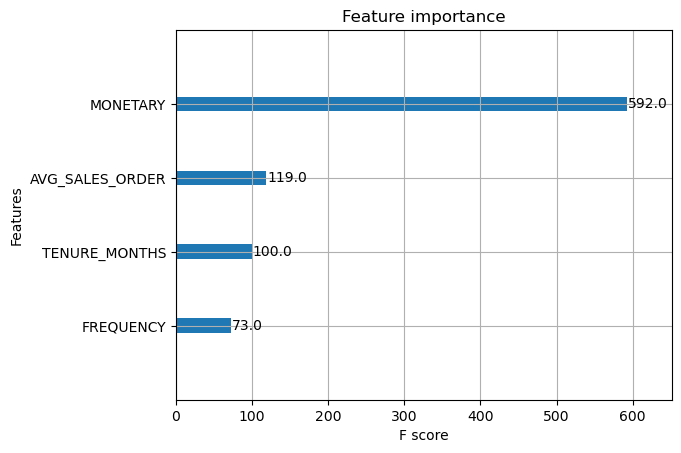

In [56]:
xgb.plot_importance(xgb_improved)